<a href="https://colab.research.google.com/github/jpatrickweller/Data_Challenges/blob/main/Assurance_Data_Challenge_JPW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Bring in the usual suspects
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import pandas_profiling as pp

register_matplotlib_converters()

In [2]:
# # Just a finicky thing about running pandas profiling in colab
# ! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
# import pandas_profiling as pp

**The goal**

In the summer of 2018, we noticed significant changes in the performance of our agents and  overall life insurance business. Marketing claimed they had changed nothing, and sales was failing to  perform. Sales claimed that marketing was bringing in low quality traffic. 
Take a look at the attached data and perform an analysis to understand what happened over this 4  month period. Here are a few questions to guide you: 
1. What changed over this time period in terms of the total performance of the life insurance  business? 
2. Is there any evidence that the quality of marketing might have changed and contributed to any  of the changes? 
3. Is there any evidence that the sales team performance is any better or worse? 
4. How would you summarize the performance of the life insurance group at Assurance over these  4 months? 



In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving analysis_data_test.csv to analysis_data_test.csv
User uploaded file "analysis_data_test.csv" with length 45797422 bytes


# EDA


In [4]:
# Read in the data
df_orig = pd.read_csv('analysis_data_test.csv')

In [5]:
# Stylin' and profilin'
# profile = pp.ProfileReport(df_orig, title="Sales Data", html={'style':{'full_width': True}})
# profile

In [6]:
df_orig.head()

,marketing_source,shopper_creation_timestamp_pst,shopper_id,number_calls_answered,number_calls_longer_than_200seconds,partner_revenue,marketing_cost,policies_submitted,policy_value
0,AH,2018-05-01 6:22,4611274,0,0,0.00,0.0,0,0.0
1,AJ,2018-05-03 4:24,4657039,1,0,3.69,0.0,0,0.0
2,BG,2018-05-06 16:38,4717844,0,0,9.60,4.0,0,0.0
3,BD,2018-05-10 21:39,4812602,0,0,0.00,0.0,0,0.0
4,Unknown,2018-05-21 9:05,5000656,0,0,0.00,0.0,0,0.0


In [7]:
# Some EDA here

# I'll begin my making a copy of the original, just in case I mess it up and want the original back.
df = df_orig.copy()

# Dropping the one row of nans
df.dropna(inplace=True)

# rename some columns to match the desription
df.rename(columns={'policies_submitted':'policies_sold'},inplace=True)

# Make some new time columns, for ease of grouping by day and week
df['shopper_creation_timestamp_pst'] = pd.to_datetime(df['shopper_creation_timestamp_pst'])
df['shopper_created_day'] = df.shopper_creation_timestamp_pst.dt.floor('D')
df['shopper_created_week'] = df.shopper_created_day - pd.to_timedelta(df.shopper_creation_timestamp_pst.dt.dayofweek,unit='D')

# Correct some datatypes
df['shopper_id'] = df['shopper_id'].astype(int)

# Make a new column to count unique customers who have answered a call
df['converted_to_call'] = df.number_calls_answered > 0

# Make a new column to count unique customers converted from call to opportunity
df['converted_to_opp'] = df.number_calls_longer_than_200seconds > 0

# Make a new column to count unique customers converted from opp to policy
df['converted_to_policy'] = df.policies_sold > 0

# Make a new column to count unique customers converted from opp to partner
df['converted_to_partner'] = df.partner_revenue > 0

# Plotting functions

In [8]:
def plot_ts(data, norm=False):

    # ok now the plotting
    plt.figure(figsize=(12,5))
    
    # Plot the data
    # If normalized
    if norm:
        x_vals = data.apply(lambda x: x/max(x))
        plt.ylabel("Normalized number of events",fontsize=16)
    
    # Raw values
    else:
        x_vals = data

    # Loop over columns to insert label and marked events
    for col in data:
        plt.plot(x_vals[col],'-o',label=col)

    # Mark the events
    mark_anomalystic_events(data)

    # Labels and axis stuff
    plt.title("Events Over Time",fontsize=20)
    plt.xlabel("Customer Registration Date",fontsize=16)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
    make_week_marks(data)
    plt.show()

def mark_anomalystic_events(data):

    # some post-priori variables
    holiday = pd.to_datetime('2018-07-04')
    shoppers_anom_week = dt.datetime(2018,6,25)
    shoppers_anom_day = dt.datetime(2018,6,27)

    # Mark the events
    plt.axvline(x=holiday,linestyle='-.',color='k', label='4th of July Holiday', alpha=.5)
    plt.axvline(x=shoppers_anom_week,linestyle='--',color='r', label='Shoppers influx',alpha=.8)
    

def make_week_marks(data):

    # vertical line every Monday
    weeks = pd.date_range(start=data.index.min(), end=data.index.max(), freq="W-MON")
    for week in weeks:
        plt.axvline(x=week, linestyle='--', color='k', alpha=.2)
    
    # Label every other monday
    plt.xticks(weeks[0::2])



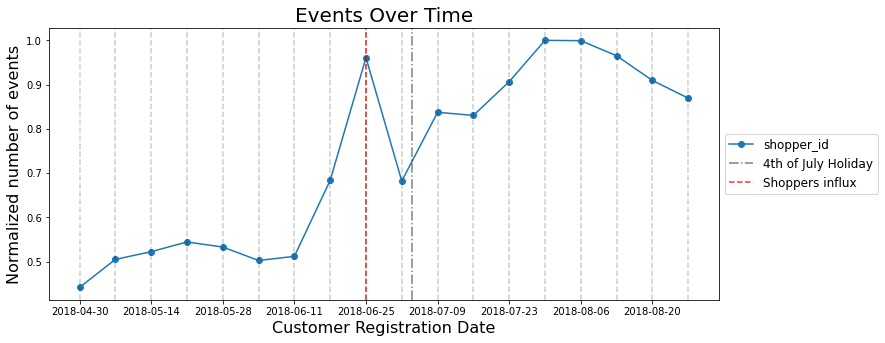

In [9]:
# Great! Now I want to look at the acquisition of shoppers over time, just to test this out.
plot_ts(df.groupby(['shopper_created_week'])[['shopper_id']].count(), norm=True)


# Weekly and Daily breakdowns

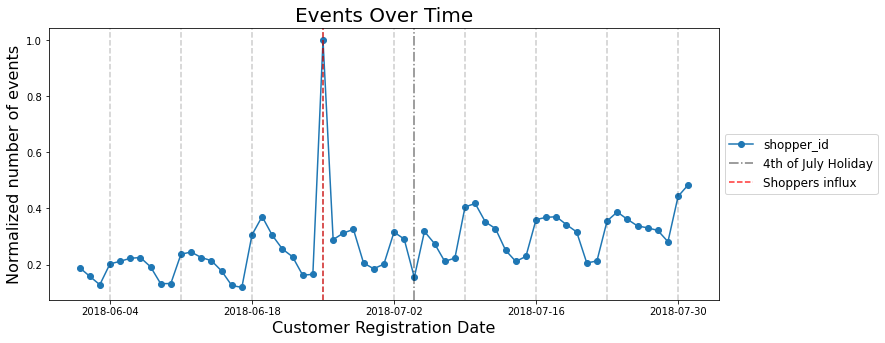

Date of the anomylous calls spike: 2018-06-25 00:00:00


In [10]:
# I want to look a little more granularly around this bump.
# I'll narrow my scope to June and July

# narrow the window
data_JJ = df[(df.shopper_creation_timestamp_pst.dt.month == 6) | (df.shopper_creation_timestamp_pst.dt.month == 7)]

# Look daily
data = data_JJ.groupby(['shopper_created_day'])[['shopper_id']].count()
plot_ts(data, norm=True)

# Find the oddball day for reference
idx_max = data.idxmax()
event_date = idx_max['shopper_id']
print(f"Date of the anomylous calls spike: {event_date}")

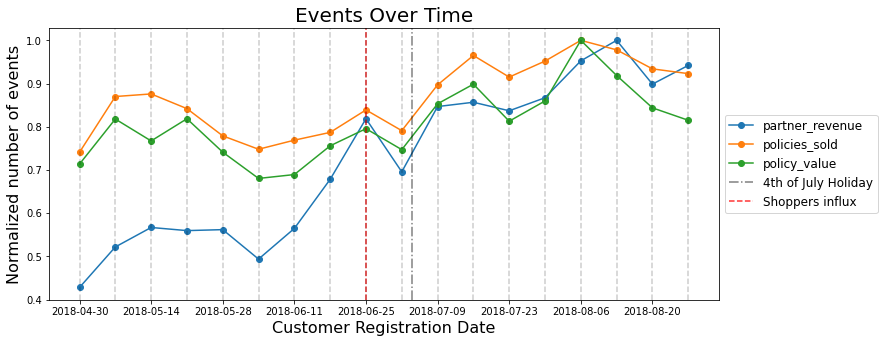

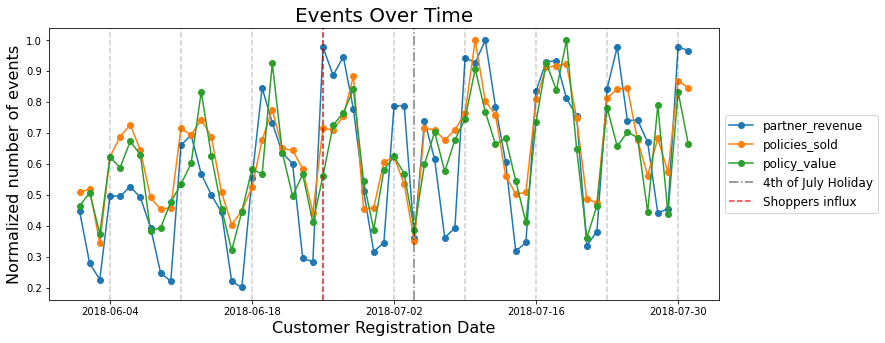

In [11]:
# Alrighty, lets look at the bottom line: revenue
vars_of_interest = [
                    'partner_revenue',
                    'policies_sold',	
                    'policy_value'
                    ]

# Show me weekly
data = df.groupby(['shopper_created_week'])[vars_of_interest].sum()
plot_ts(data, norm=True)

# Show me daily
data = data_JJ.groupby(['shopper_created_day'])[vars_of_interest].sum()
plot_ts(data, norm=True)


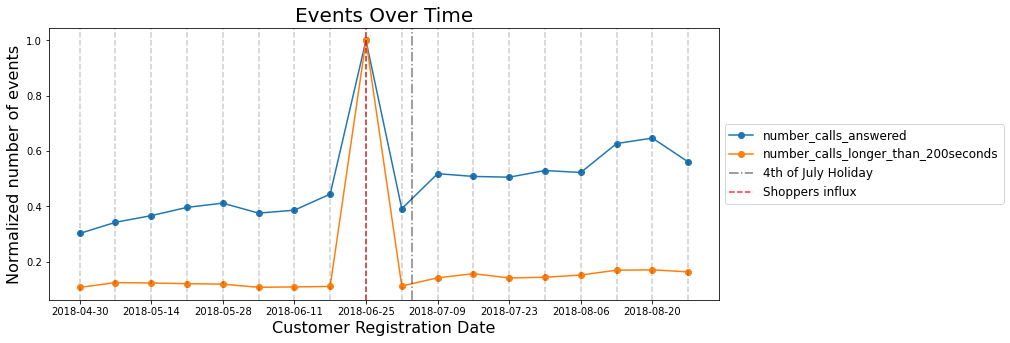

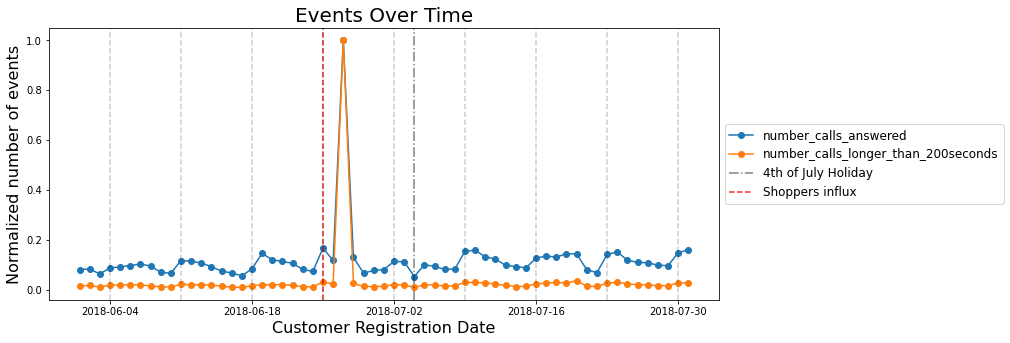

In [12]:
# Sales
vars_of_interest = [                    
                    'number_calls_answered', 
                    'number_calls_longer_than_200seconds'
                    ]

# Look weekly
plot_ts(df.groupby(['shopper_created_week'])[vars_of_interest].sum(), norm=True)

# Show me daily
plot_ts(data_JJ.groupby(['shopper_created_day'])[vars_of_interest].sum(), norm=True)

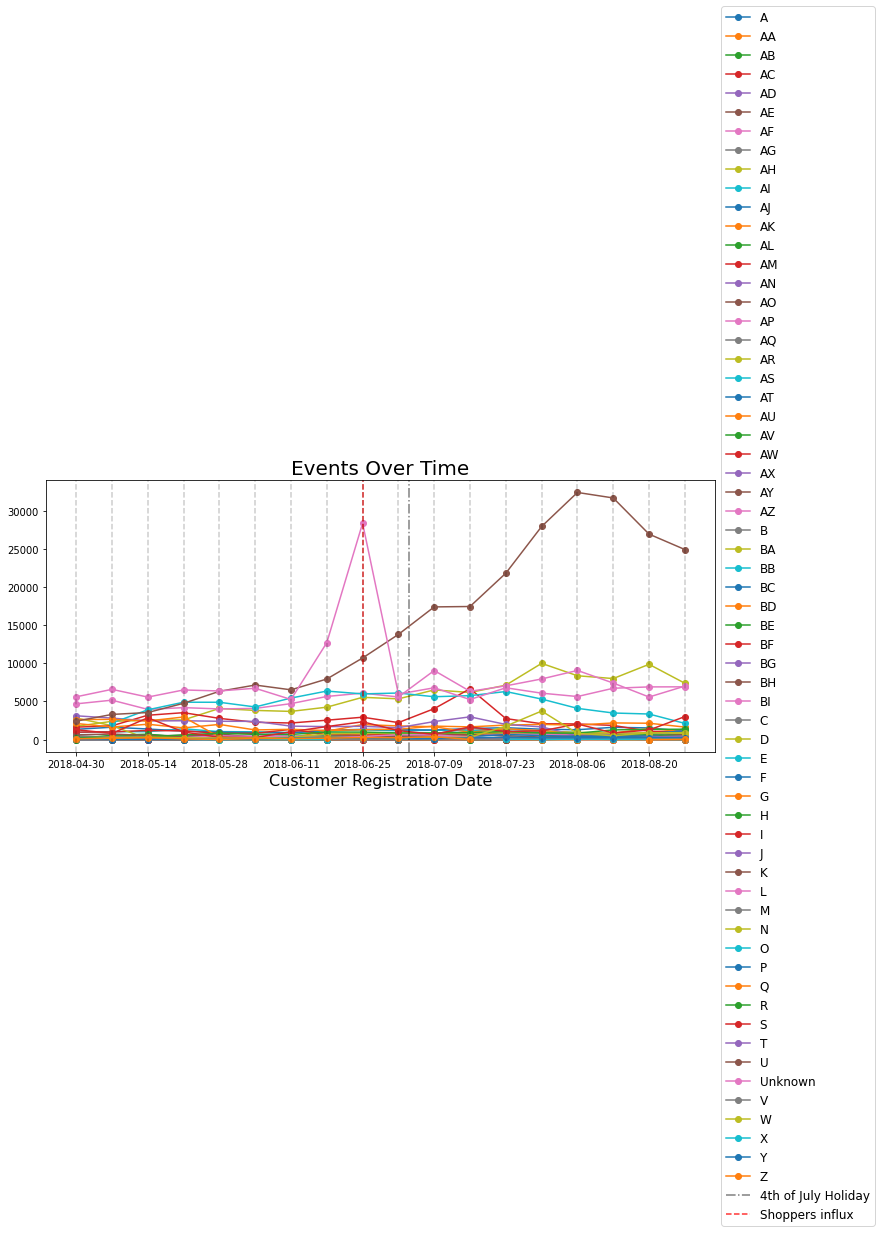

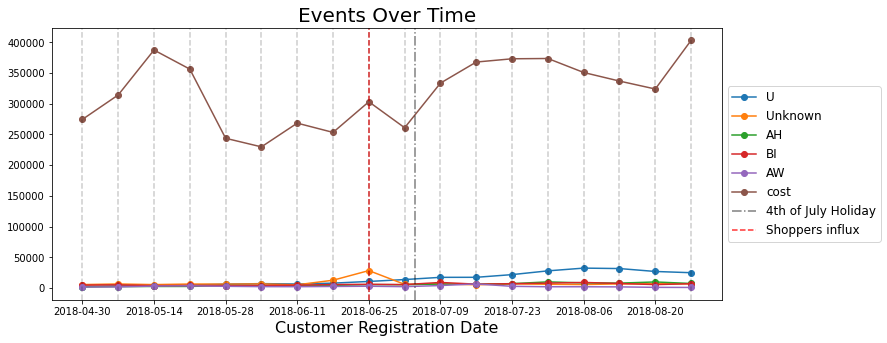

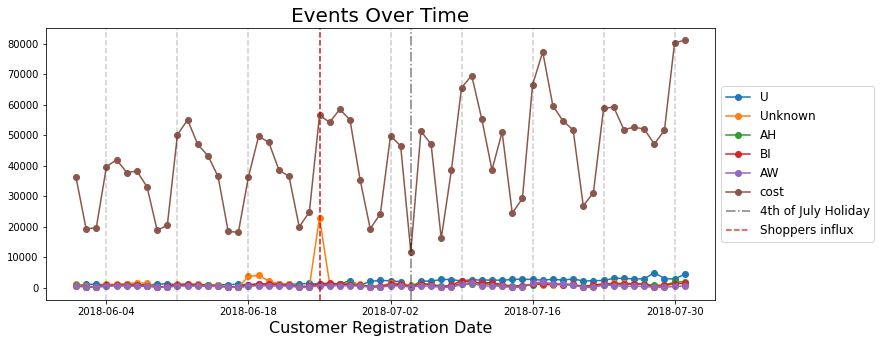

In [13]:
# Marketing

# The chaos that is all the marketing sources
plot_ts(df.groupby(['shopper_created_week'])['marketing_source'].value_counts().unstack())

# Pull out the top couple marketing sources
data = df.groupby(['shopper_created_week'])['marketing_source'].value_counts().unstack()
most_pop_sources = data.max().nlargest(5).index
marketing = data[most_pop_sources].copy()

# Add in the other marketing data
marketing['cost'] = df.groupby(['shopper_created_week'])[['marketing_cost']].sum()

# show me!
plot_ts(marketing, norm=False)

# And now the same for the daily data
sources = data_JJ.groupby(['shopper_created_day'])['marketing_source'].value_counts().unstack()
marketing = sources[most_pop_sources].copy()
marketing['cost'] = df.groupby(['shopper_created_day'])[['marketing_cost']].sum()
plot_ts(marketing, norm=False)

# Ok looks like source "U" rises a lot over time. LIke a lot a lot. more than 10x.
# It also appears that the "unknown" marketing source spikes at the same time
# as the spike in new shoppers. Whatever this marketing push, it was big and
# brought in a lot of new potential customers! But were they quality?

In [14]:
data = df.groupby(['shopper_created_week'])['marketing_source'].value_counts().unstack()
data.max().nlargest(10).index

Index(['U', 'Unknown', 'AH', 'BI', 'AW', 'O', 'W', 'BG', 'S', 'Q'], dtype='object', name='marketing_source')

In [15]:
# Looks like there are two different notable marketing events here.

# Event 1: anomalistic influx of shoppers from unknown source on June 27. This is super suss.

# Event 2: a pronounced rise of 1 completely dominant marketing source for the 
# gain in customers starting July through August.

In [16]:
# This spike of new customers is weird.
# Looks like there was a flurry of inbounds from an unknown source. I don't know
# how many calls the sales team made that week, but the total number of answered
# calls looks consistent with the week before and 2 weeks after (1 week following
# is the 4th of July, so the dip is expected). However, the successful call rate
# appears to dip.

# My hunch at this point is that a bot made a bunch of new accounts at one time,
# and of course none of these bots bought policies. So the apparent dip from the 
# sales team call rate just reflects the enormous influx of fake customers. This
# explanation is also consistent with the Sales teams' claim that Marketing 
# brought in bad leads, despite no changes from the Marketing teams' strategy.

# Weekly metrics

In [74]:
# Now I want to build some weekly metrics.

# Group by week
grouped = df.groupby('shopper_created_week')

# Make a new df
weekly_df = pd.DataFrame(index=grouped.groups)

# Start with total new shoppers and work my way down the funnel
new_users = grouped[['shopper_id']].count().rename(columns={'shopper_id':'total_new_shoppers'})
weekly_df = weekly_df.join(new_users)

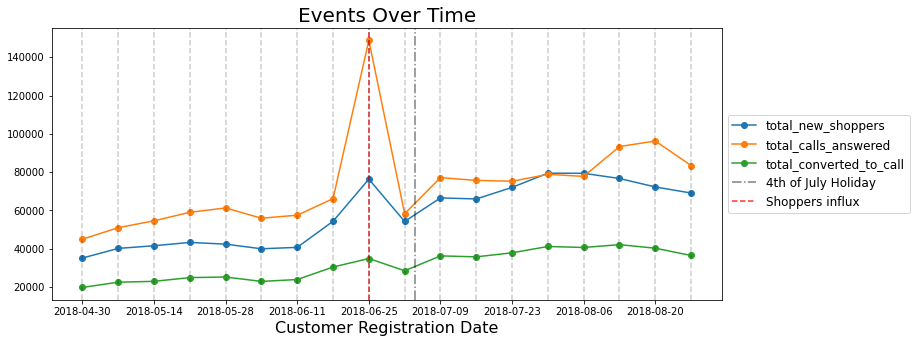

In [75]:
# New shoppers to calls
metrics = grouped['number_calls_answered'].agg([
                    "sum",
                    "mean"
                ]).rename(columns={
                    "sum":"total_calls_answered",
                    "mean":'mean_calls_answered'
                })
weekly_df = weekly_df.join(metrics)
weekly_df['total_converted_to_call'] = grouped['converted_to_call'].sum()
weekly_df['inbound_to_call_conv_rate'] = weekly_df.total_converted_to_call / weekly_df.total_new_shoppers

# Compare Shoppers to calls
plot_ts(weekly_df[['total_new_shoppers','total_calls_answered', 'total_converted_to_call']], norm=False)


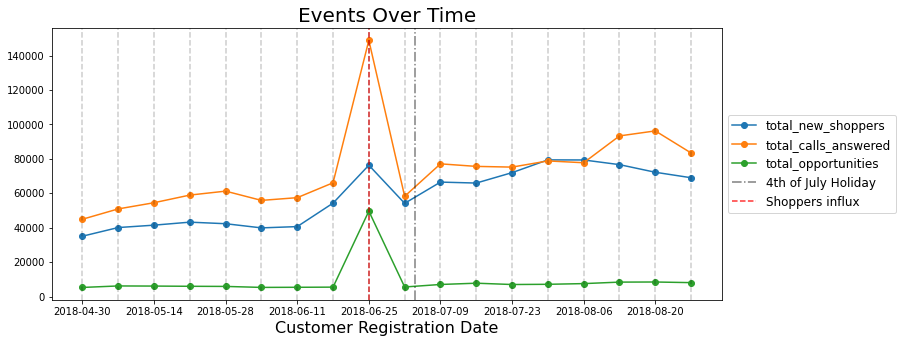

In [76]:
# Calls to opportunity
metrics = grouped['number_calls_longer_than_200seconds'].agg([
                    "sum",
                    "mean"
                ]).rename(columns={
                    "sum":"total_opportunities",
                    "mean":"mean_opportunities"
                })
weekly_df = weekly_df.join(metrics)
weekly_df['total_converted_to_opp'] = grouped['converted_to_opp'].sum()
weekly_df['call_to_opp_conv_rate'] = weekly_df.total_converted_to_opp / weekly_df.total_converted_to_call

plot_ts(weekly_df[['total_new_shoppers','total_calls_answered','total_opportunities']], norm=False)

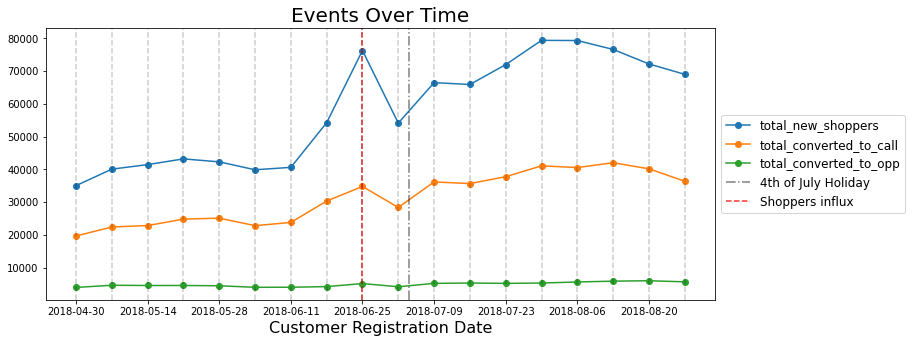

In [77]:
# Look at the pipelines
plot_ts(weekly_df[['total_new_shoppers','total_converted_to_call','total_converted_to_opp']], norm=False)

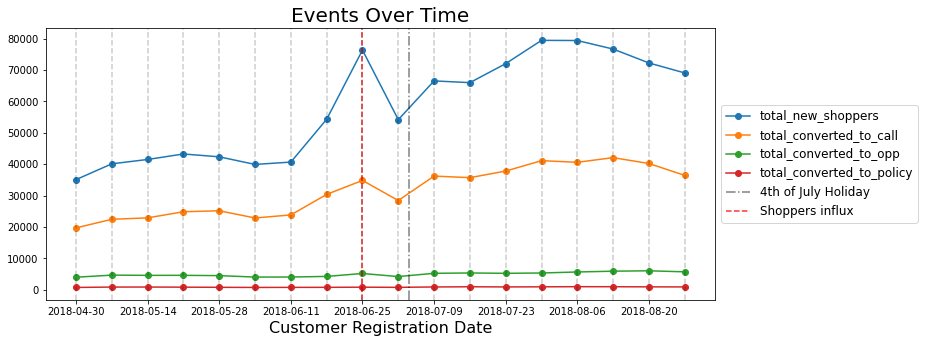

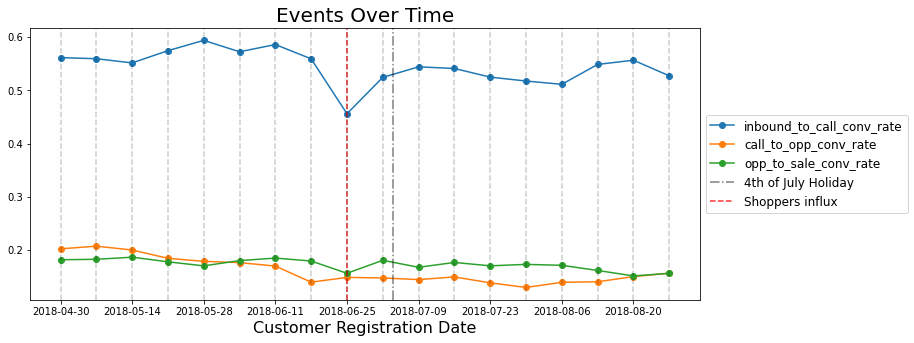

In [78]:
# Opportunity to Policy
weekly_df['total_policies_sold'] = grouped['policies_sold'].sum()
weekly_df['total_converted_to_policy'] = grouped['converted_to_policy'].sum()
weekly_df['opp_to_sale_conv_rate'] = weekly_df.total_converted_to_policy / weekly_df.total_converted_to_opp

plot_ts(weekly_df[[
                'total_new_shoppers',
                'total_converted_to_call',
                'total_converted_to_opp',
                'total_converted_to_policy'
                ]], norm=False)
plot_ts(weekly_df[[
                   'inbound_to_call_conv_rate',
                   'call_to_opp_conv_rate',
                   'opp_to_sale_conv_rate'
                ]])

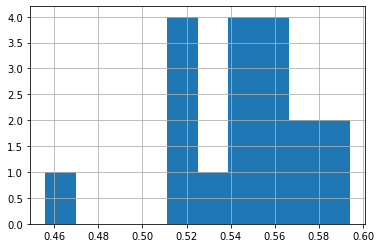

In [79]:
weekly_df['inbound_to_call_conv_rate'].hist()
                #    'call_to_opp_conv_rate',
                #    'opp_to_sale_conv_rate'

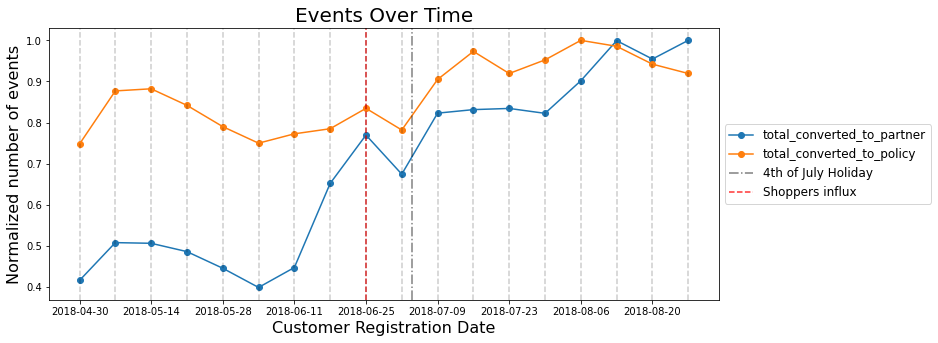

In [80]:
# Opportunity to Partner revenue
weekly_df['total_converted_to_partner'] = grouped['converted_to_partner'].sum()
weekly_df['opp_to_partner_conv_rate'] = weekly_df.total_converted_to_partner / weekly_df.total_converted_to_opp

plot_ts(weekly_df[[
                'total_converted_to_partner',
                'total_converted_to_policy'
                ]], norm=True)

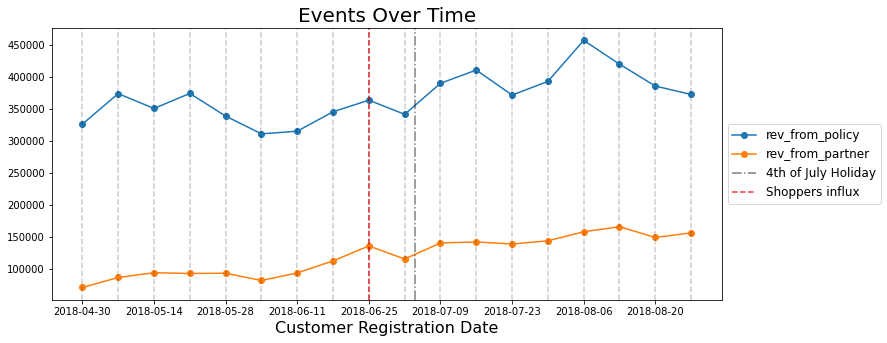

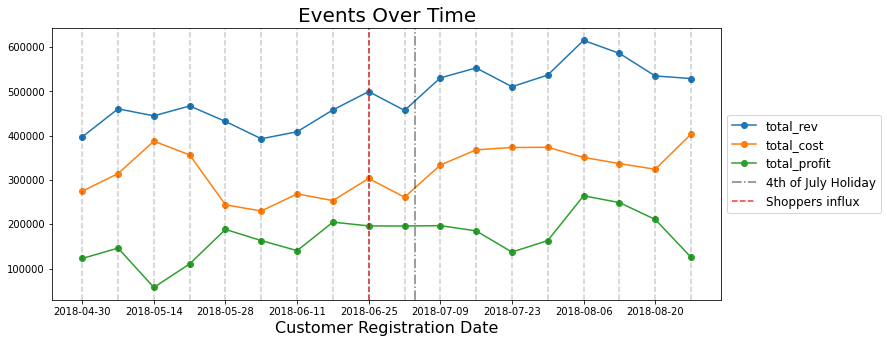

In [81]:
# Expenditures
weekly_df['total_cost'] = grouped['marketing_cost'].sum()

# Revenue
weekly_df['rev_from_policy'] = grouped['policy_value'].sum()
weekly_df['rev_from_partner'] = grouped['partner_revenue'].sum()
weekly_df['total_rev'] = weekly_df.rev_from_policy + weekly_df.rev_from_partner

# Profit
weekly_df['total_profit'] = weekly_df.total_rev - weekly_df.total_cost

# Show me
plot_ts(weekly_df[['rev_from_policy', 'rev_from_partner']])
plot_ts(weekly_df[['total_rev', 'total_cost','total_profit']])

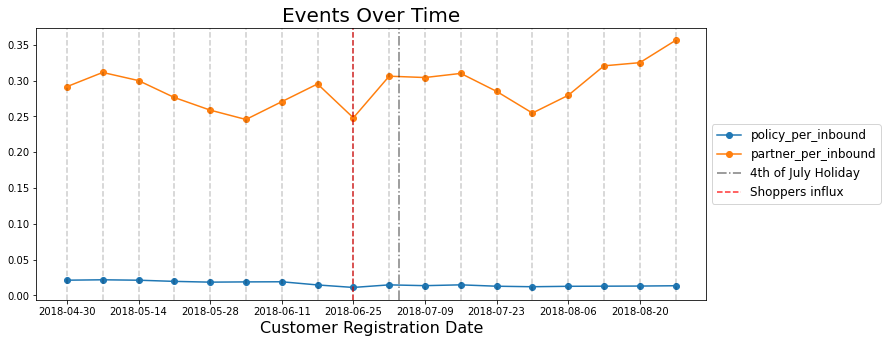

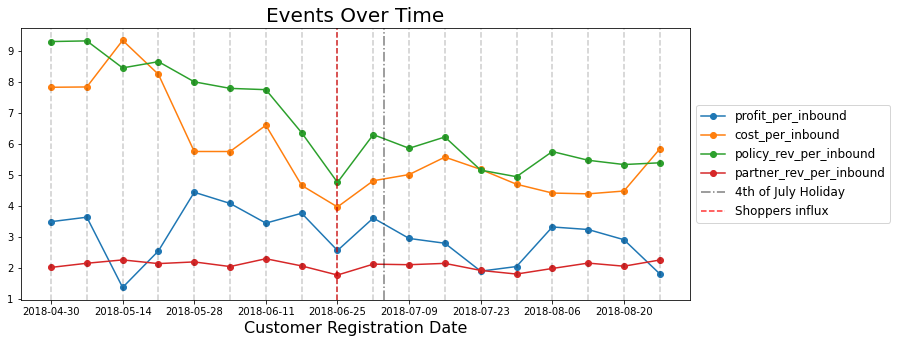

In [82]:
# policy per inbound
weekly_df['policy_per_inbound'] = weekly_df.total_policies_sold / weekly_df.total_new_shoppers
weekly_df['partner_per_inbound'] = weekly_df.total_converted_to_partner / weekly_df.total_new_shoppers

# Policy per inbound
weekly_df['policy_rev_per_inbound'] = weekly_df.rev_from_policy / weekly_df.total_new_shoppers

# Partner per inbound
weekly_df['partner_rev_per_inbound'] = weekly_df.rev_from_partner / weekly_df.total_new_shoppers

# profit per inbound
weekly_df['profit_per_inbound'] = weekly_df.total_profit / weekly_df.total_new_shoppers

# Cost per inbound
weekly_df['cost_per_inbound'] = weekly_df.total_cost / weekly_df.total_new_shoppers

# Compare
plot_ts(weekly_df[['policy_per_inbound','partner_per_inbound']])
plot_ts(weekly_df[['profit_per_inbound','cost_per_inbound','policy_rev_per_inbound','partner_rev_per_inbound']])


In [83]:
weekly_df

,total_new_shoppers,total_calls_answered,mean_calls_answered,total_converted_to_call,inbound_to_call_conv_rate,total_opportunities,mean_opportunities,total_converted_to_opp,call_to_opp_conv_rate,total_policies_sold,total_converted_to_policy,opp_to_sale_conv_rate,total_converted_to_partner,opp_to_partner_conv_rate,total_cost,rev_from_policy,rev_from_partner,total_rev,total_profit,policy_per_inbound,partner_per_inbound,policy_rev_per_inbound,partner_rev_per_inbound,profit_per_inbound,cost_per_inbound
2018-04-30,35062,44909,1.280845,19688,0.561520,5294,0.150990,3980,0.202154,741,723,0.181658,10226,2.569347,274529.10,326171.507,71043.76,397215.267,122686.167,0.021134,0.291655,9.302707,2.026232,3.499121,7.829819
2018-05-07,40093,50916,1.269947,22431,0.559474,6163,0.153718,4647,0.207169,870,848,0.182483,12491,2.687971,314317.09,373823.405,86592.17,460415.575,146098.485,0.021700,0.311551,9.323907,2.159783,3.643990,7.839700
2018-05-14,41479,54517,1.314328,22880,0.551604,6093,0.146894,4575,0.199956,876,853,0.186448,12451,2.721530,387467.75,350654.759,94073.94,444728.699,57260.949,0.021119,0.300176,8.453790,2.267990,1.380480,9.341299
2018-05-21,43225,58955,1.363910,24836,0.574575,5966,0.138022,4579,0.184369,842,814,0.177768,11953,2.610395,356412.23,374108.126,92871.80,466979.926,110567.696,0.019479,0.276530,8.654902,2.148567,2.557957,8.245511
2018-05-28,42321,61249,1.447248,25138,0.593984,5889,0.139151,4490,0.178614,779,764,0.170156,10957,2.440312,243800.90,338788.268,93243.96,432032.228,188231.328,0.018407,0.258902,8.005205,2.203255,4.447705,5.760755
2018-06-04,39900,55873,1.400326,22844,0.572531,5320,0.133333,4027,0.176283,748,725,0.180035,9807,2.435312,229821.66,310987.573,81931.27,392918.843,163097.183,0.018747,0.245789,7.794175,2.053415,4.087649,5.759941
2018-06-11,40643,57455,1.413651,23820,0.586079,5388,0.132569,4043,0.169731,769,747,0.184764,11001,2.720999,268456.76,315089.180,93704.87,408794.050,140337.290,0.018921,0.270674,7.752606,2.305560,3.452926,6.605240
2018-06-18,54279,66100,1.217782,30355,0.559240,5475,0.100868,4235,0.139516,787,759,0.179221,16037,3.786777,253369.11,345488.422,112566.41,458054.832,204685.722,0.014499,0.295455,6.365048,2.073848,3.770993,4.667903
2018-06-25,76312,148851,1.950558,34803,0.456062,49630,0.650356,5167,0.148464,839,807,0.156183,18933,3.664215,303257.63,363611.083,135837.01,499448.093,196190.463,0.010994,0.248100,4.764796,1.780022,2.570899,3.973918
2018-07-02,54160,58252,1.075554,28402,0.524409,5557,0.102603,4186,0.147384,791,756,0.180602,16590,3.963211,260968.38,341441.269,115435.23,456876.499,195908.119,0.014605,0.306315,6.304307,2.131374,3.617210,4.818471


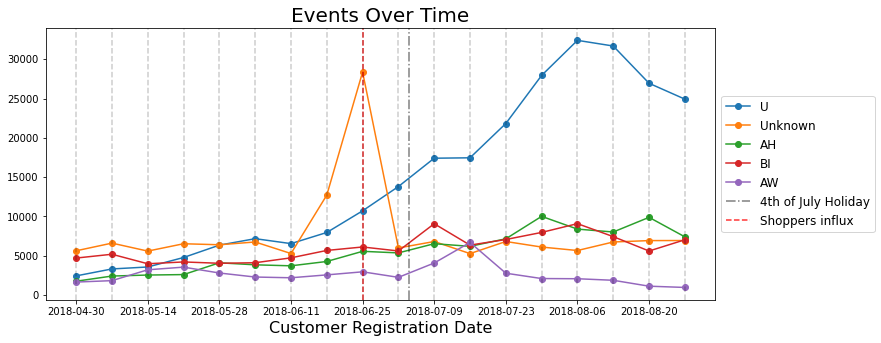

In [84]:
# Now lets break down the marketing sources

markets = df.groupby(['shopper_created_week','marketing_source'])['policies_sold'].count().unstack().fillna(0)
plot_ts(markets.loc[:,most_pop_sources])

# display(weekly_df)
# grouped["C"]
#    ....:     .agg([np.sum, np.mean, np.std])
#    ....:     .rename(columns={"sum": "foo", "mean": "bar", "std": "baz"})

# df.groupby(["Store", "Product"])
#    .....:     .pipe(lambda grp: grp.Revenue.sum() / grp.Quantity.sum())
#    .....:     .unstack()
#    .....:     .round(2)

# # Compare some of these
# plot_ts(weekly_df[['total_new_shoppers','mean_calls_answered','mean_calls_converted']], norm=True)
# plot_ts(weekly_df[['total_new_shoppers','call_conversion_rate']], norm=True)

# This is for unique customers - filter on calls answered > 0
#sf.groupby(sf).filter(lambda x: x.sum() > 2)

# Marketing Sources

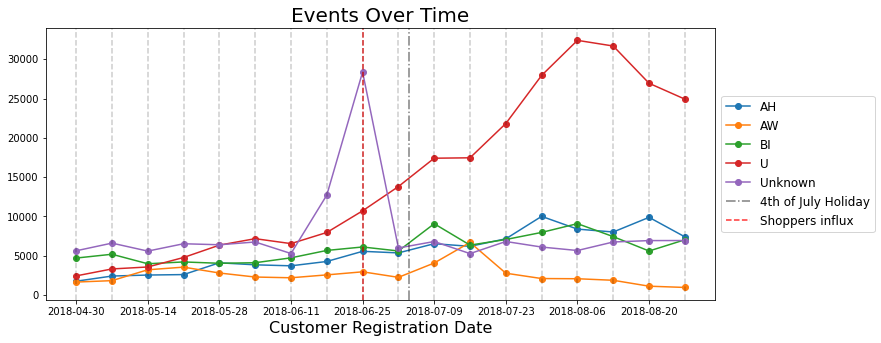

In [85]:
# Let's look at the market sources. 

# Group by week
market_grouped = df.groupby(['shopper_created_week','marketing_source'])

# Make a new df
markets_df = pd.DataFrame(index=market_grouped.groups)
markets_df.index.set_names(['date', 'marketing_source'], inplace=True)

# Pull out shoppers that came from that source
markets_df['total_inbounds_from_source'] = market_grouped['shopper_id'].count().fillna(0)

# Plot the top few marketing sources
data = markets_df.loc[(slice(None),most_pop_sources),"total_inbounds_from_source"].unstack()
plot_ts(data)

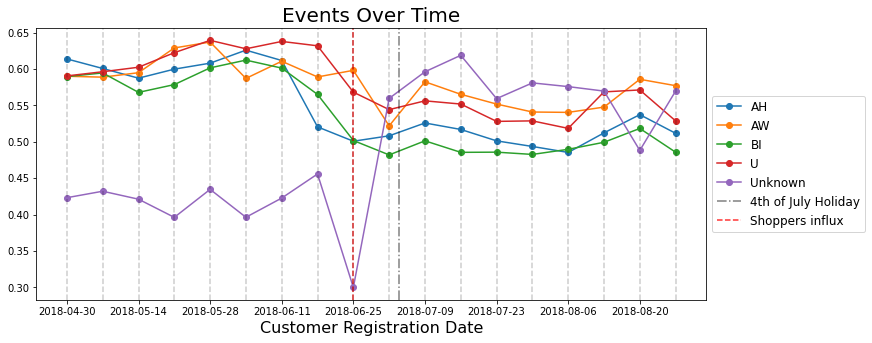

In [86]:
# Inbound to call conversion rate

# How many total shoppers from each source converted to call
markets_df['total_calls'] = market_grouped['number_calls_answered'].sum().fillna(0)

# How many unique shoppers from each source converted to call
markets_df['total_converted_to_call'] = market_grouped['converted_to_call'].sum().fillna(0)

# Conversion rate from inbound to call
markets_df['inbound_to_call_conv_rate'] = markets_df.total_converted_to_call / markets_df.total_inbounds_from_source

# Plot
data = markets_df.loc[(slice(None),most_pop_sources),'inbound_to_call_conv_rate'].unstack()
plot_ts(data)

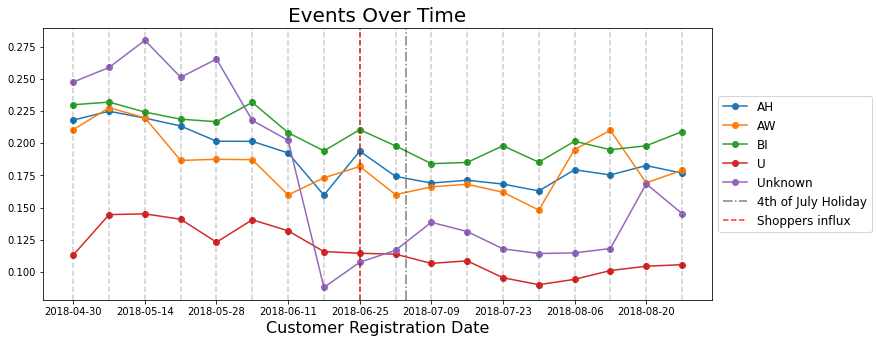

In [87]:
# Call to opportunity conversion rate

# How many total shoppers from each source converted to call
markets_df['total_opp_from_source'] = market_grouped['number_calls_longer_than_200seconds'].sum().fillna(0)

# How many unique shoppers from each source converted to call
markets_df['total_converted_to_opp'] = market_grouped['converted_to_opp'].sum().fillna(0)

# Conversion rate from inbound to call
markets_df['call_to_opp_conv_rate'] = markets_df.total_converted_to_opp / markets_df.total_converted_to_call

# Plot
data = markets_df.loc[(slice(None),most_pop_sources),'call_to_opp_conv_rate'].unstack()
plot_ts(data)

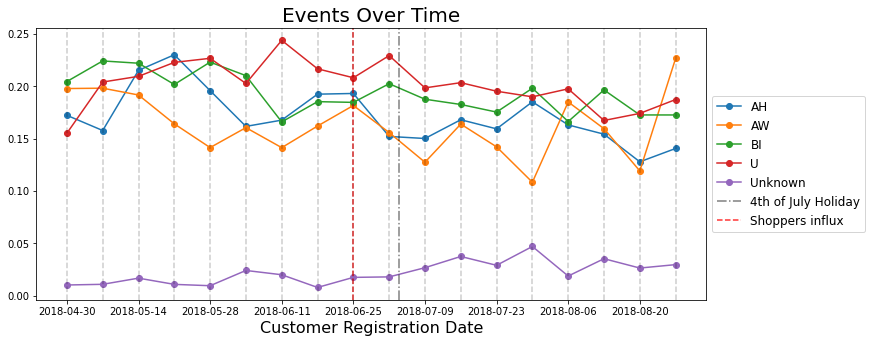

In [88]:
# Opp to sale conversion rate

# How many total shoppers from each source converted to sale
markets_df['total_sales_from_source'] = market_grouped['policies_sold'].sum().fillna(0)

# How many unique shoppers from each source converted to sale
markets_df['total_converted_to_policy'] = market_grouped['converted_to_policy'].sum().fillna(0)

# Conversion rate from opp to sale
markets_df['opp_to_sale_conv_rate'] = markets_df.total_converted_to_policy / markets_df.total_converted_to_opp

# Plot
data = markets_df.loc[(slice(None),most_pop_sources),'opp_to_sale_conv_rate'].unstack()
plot_ts(data)

Cost from source


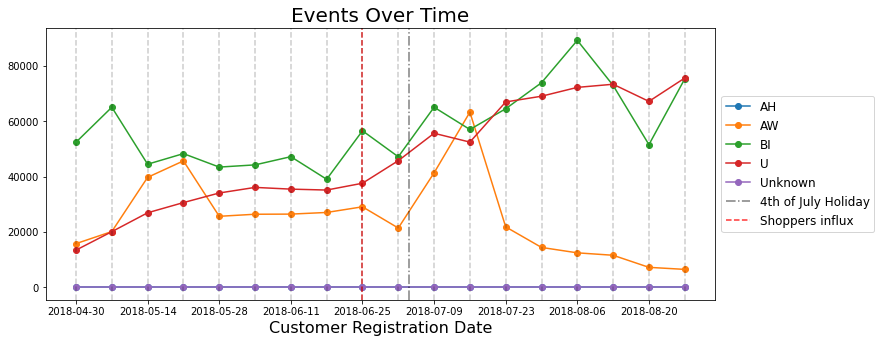

rev from policy


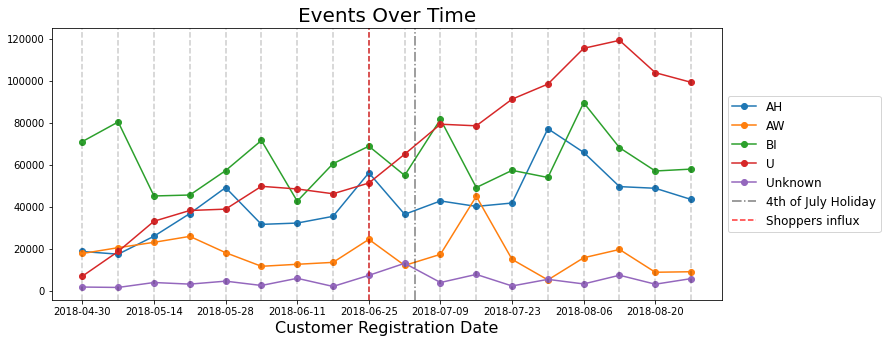

rev from partner


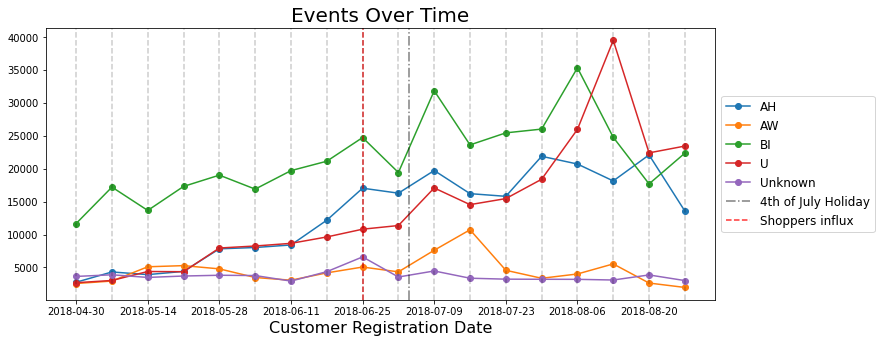

total rev from source


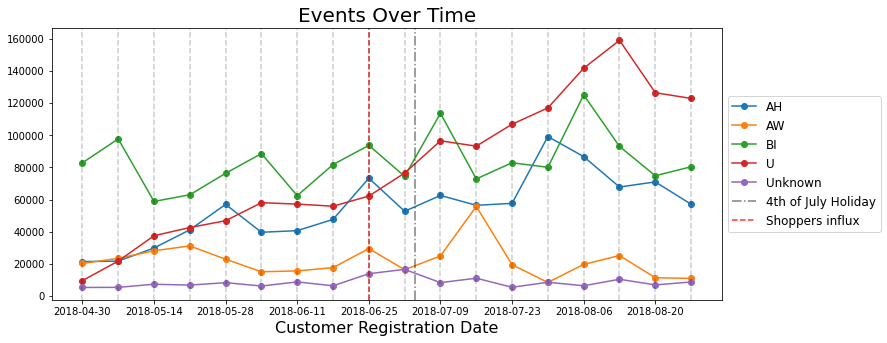

In [89]:
# Ok now I want to look at costs and revenue per source stream

# Total cost from each source
markets_df['cost_from_source'] = market_grouped['marketing_cost'].sum()

# Total revenue from each source
markets_df['revenue_from_policy'] = market_grouped['policy_value'].sum()

# Partner rev
markets_df['revenue_from_partner'] = market_grouped['partner_revenue'].sum()

# Total revenue
markets_df['total_revenue_from_source'] = markets_df.revenue_from_policy + markets_df.revenue_from_partner

# Plot them!
print('Cost from source')
data = markets_df.loc[(slice(None),most_pop_sources),'cost_from_source'].unstack()
plot_ts(data)

print('rev from policy')
data = markets_df.loc[(slice(None),most_pop_sources),'revenue_from_policy'].unstack()
plot_ts(data)

print('rev from partner')
data = markets_df.loc[(slice(None),most_pop_sources),'revenue_from_partner'].unstack()
plot_ts(data)

print('total rev from source')
data = markets_df.loc[(slice(None),most_pop_sources),'total_revenue_from_source'].unstack()
plot_ts(data)

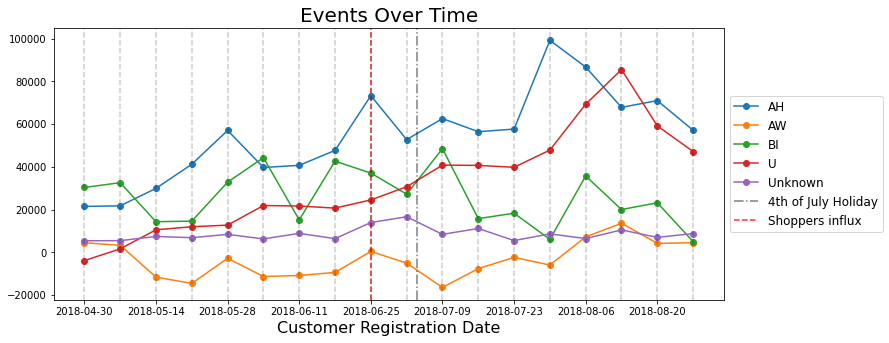

In [90]:
markets_df['rev_per_dollar_cost'] =  markets_df.total_revenue_from_source - markets_df.cost_from_source

data = markets_df.loc[(slice(None),most_pop_sources),'rev_per_dollar_cost'].unstack()
plot_ts(data)

In [91]:
data.columns

# df.groupby(["Store", "Product"])
#    .....:     .pipe(lambda grp: grp.Revenue.sum() / grp.Quantity.sum())
#    .....:     .unstack()
#    .....:     .round(2)

Index(['AH', 'AW', 'BI', 'U', 'Unknown'], dtype='object', name='marketing_source')

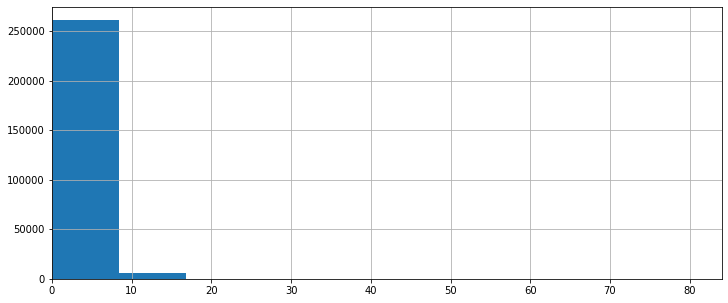

In [92]:
data = df[df.marketing_source == 'U'].marketing_cost

plt.figure(figsize=(12,5))
data.hist()
plt.xlim([0, data.max()])
plt.show()

In [93]:
markets_df.rev_per_dollar_cost.unstack()

marketing_source,A,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN,AO,AP,AQ,AR,AS,AT,AU,AV,AW,AX,AY,AZ,B,BA,BB,BC,BD,BE,BF,BG,BH,BI,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,Unknown,V,W,X,Y,Z
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-04-30,7779.662,871.657,-733.961,3343.589,341.120,2921.416,1386.195,1593.512,21513.063,155.961,16744.342,-2573.833,-3064.939,-203.624,-426.730,762.286,69.380,1764.027,-3381.188,593.499,NaN,NaN,-1037.758,4518.061,472.462,-13.250,2639.802,1857.038,-90.440,365.968,-203.730,11532.640,-19.690,157.624,7910.778,17510.025,30389.174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3751.281,503.169,-9408.489,-172.557,-3830.010,5440.896,-393.680,-48.872,NaN,92.560,1307.731
2018-05-07,15180.461,80.510,104.350,3351.162,2921.707,1465.839,3400.311,-4169.917,21792.403,283.796,23803.957,-1279.987,-1969.267,5265.713,866.398,4895.980,1339.585,405.357,-3069.009,1302.394,-11.000,-52.130,-322.461,3306.075,1565.660,292.617,-1962.598,NaN,1384.528,993.531,603.555,10115.375,-48.000,-7.770,903.142,1227.149,32628.516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3620.055,381.475,8605.689,-2253.798,1883.568,2581.070,1649.446,5497.894,-2177.662,-1301.007,NaN,14.510,1009.313
2018-05-14,8721.465,47.570,-610.290,-599.281,2048.877,11.130,-1393.548,-875.368,29959.838,-3172.740,14670.228,-988.523,3021.202,-3223.459,-229.762,-609.480,12.730,676.900,252.228,-206.820,NaN,518.302,-5261.254,-11575.543,62.846,-50.080,-1316.805,NaN,493.042,1169.739,-237.910,11341.547,-85.900,-1.780,-6168.117,3428.021,14359.019,NaN,NaN,NaN,NaN,NaN,NaN,330.521,NaN,NaN,NaN,NaN,NaN,-2211.250,740.187,5687.255,1196.766,-17500.990,-736.090,10582.334,7448.202,-2556.215,-119.717,NaN,69.480,142.442
2018-05-21,12234.198,784.970,11.392,3304.897,526.081,482.868,-404.153,-1290.908,41254.426,1546.046,1073.031,63.822,-2684.685,10175.145,-291.960,-8.810,82.810,-60.227,341.982,413.642,NaN,-22.770,2724.649,-14508.233,-764.500,876.828,-1801.441,NaN,-105.980,1376.947,-68.660,7776.967,-73.440,-8.500,5164.297,-532.951,14644.702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.250,-1066.760,-124.884,NaN,-3936.785,794.546,17926.841,-2835.352,2527.707,-970.630,11991.980,6892.528,-89.531,-2566.436,0.000,0.000,-214.260
2018-05-28,15017.978,786.512,537.007,1309.214,1951.317,2786.491,345.239,2896.963,57079.999,1822.175,778.491,-968.533,-208.486,7490.396,2226.896,101.878,140.540,-511.028,5.600,-167.490,NaN,-558.440,135.039,-2741.868,520.503,704.709,3394.896,NaN,266.686,-282.101,237.806,7443.797,-44.230,5.320,2454.082,7529.904,32872.406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1753.012,2605.582,-609.180,721.059,12415.939,1330.410,1339.915,-1909.337,3905.078,-508.300,12769.867,8427.532,-75.560,-1777.980,3148.863,-545.610,-119.630
2018-06-04,7944.978,520.765,5394.235,1215.304,1171.822,6165.377,-890.778,167.066,39733.968,676.042,245.892,2166.597,1731.893,878.049,1283.295,62.460,214.150,2001.506,-42.893,267.670,NaN,-290.080,-369.288,-11294.969,2079.585,-17.380,152.259,NaN,96.876,929.683,-207.050,5614.035,-24.000,47.920,6018.558,3461.152,44333.554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,923.483,-617.140,-224.120,1108.000,5702.065,1733.235,189.153,-382.079,384.790,-457.849,21942.554,6319.943,-23.120,3063.973,0.000,1450.344,545.698
2018-06-11,9222.097,36.410,418.253,1968.586,946.483,2460.069,-925.074,832.075,40747.049,-80.950,7657.003,1205.088,1384.742,4606.287,513.227,-194.449,89.930,1829.987,0.000,794.100,-22.000,-38.010,-1482.366,-10794.933,1750.124,421.961,1427.568,NaN,-165.090,197.735,-97.690,3790.069,-16.350,0.000,849.198,386.460,15202.597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.080,2173.963,-123.970,2119.133,13736.296,134.990,1644.475,1800.067,5357.436,-388.750,21698.283,8890.312,221.364,16.514,4.050,-2146.162,222.023
2018-06-18,11597.511,173.070,85.850,4181.010,2114.101,4847.998,-6.403,241.973,47724.264,-255.923,5729.327,2023.050,1759.374,2396.866,1130.806,-88.740,187.500,3405.458,119.413,352.380,0.180,86.193,10038.730,-9365.750,-276.184,-175.470,2819.836,NaN,356.040,1749.621,733.104,6785.980,4.

In [94]:
df

,marketing_source,shopper_creation_timestamp_pst,shopper_id,number_calls_answered,number_calls_longer_than_200seconds,partner_revenue,marketing_cost,policies_sold,policy_value,shopper_created_day,shopper_created_week,converted_to_call,converted_to_opp,converted_to_policy,converted_to_partner
0,AH,2018-05-01 06:22:00,4611274,0,0,0.00,0.00,0,0.0,2018-05-01,2018-04-30,False,False,False,False
1,AJ,2018-05-03 04:24:00,4657039,1,0,3.69,0.00,0,0.0,2018-05-03,2018-04-30,True,False,False,True
2,BG,2018-05-06 16:38:00,4717844,0,0,9.60,4.00,0,0.0,2018-05-06,2018-04-30,False,False,False,True
3,BD,2018-05-10 21:39:00,4812602,0,0,0.00,0.00,0,0.0,2018-05-10,2018-05-07,False,False,False,False
4,Unknown,2018-05-21 09:05:00,5000656,0,0,0.00,0.00,0,0.0,2018-05-21,2018-05-21,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,U,2018-07-15 06:26:00,6237276,3,0,0.00,1.87,0,0.0,2018-07-15,2018-07-09,True,False,False,False
1048571,AZ,2018-07-18 08:33:00,6330650,1,0,3.10,9.60,0,0.0,2018-07-18,2018-07-16,True,False,False,True
1048572,AW,2018-07-20 11:58:00,6401348,3,0,0.00,0.00,0,0.0,2018-07-20,2018-07-16,True,False,False,False
1048573,Unknown,2018-07-24 07:51:00,6491033,0,0,0.00,0.00,0,0.0,2018-07-24,2018-07-23,False,False,False,False


In [95]:
# I need some kind of headline figure.
# workshopping a few as topline kpi:
# - revenue per customer
# - revenue per dollar spent
# - total revenue
# - dollar per shopper
# 

In [96]:
# rev per customer
grouped = df.groupby('shopper_created_week')

data = grouped['policy_value'].sum()
plot_ts(data)

KeyError: ignored

<Figure size 864x360 with 0 Axes>